In [1]:
import nasdaqdatalink  # conda install nasdaq-data-link
import yahoo_fin.stock_info as yf  # conda install yahoo_fin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore")

plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 80}) # set fig size

In [2]:
def get_datasets(source, startdate='1997-01-01', enddate='2021-12-31', auth="Gymx-B5owcdhypB7ydu8"):
    try:
        return nasdaqdatalink.get(source, start_date=startdate, end_date=enddate, authtoken=auth)
    except:
        return yf.get_data(source, start_date=startdate, end_date=enddate, interval='1mo')['adjclose'].to_frame()

features = [
  'US_gas_consumption',
  #'US_gas_supply',
  'US_storage_volume',
  'US_gas_exports',
  'US_gas_imports',
  'gas_rig_count',
  'gas_marketed_production',
  'WTI_spot_price',
  'gas_futures_1',
  #'US_PMI',  missing values
  'US_CPI',
  'dow_jones',
  '3m_treasury',
  '5y_treasury',
  #'USD/EUR'  missing values
]

API_mapping = {
    'HH_spot_price':'EIA/NG_RNGWHHD_M',
    'US_gas_consumption':'EIA/STEO_NGTCPUS_M',
    'US_gas_supply':'EIA/STEO_NGPSUPP_M',
    'US_storage_volume':'EIA/NG_N5020US2_M',
    'US_gas_exports':'EIA/NG_N9130US2_M',
    'US_gas_imports':'EIA/NG_N9100US2_M',
    'gas_rig_count':'EIA/NG_E_ERTRRG_XR0_NUS_C_M',
    'gas_futures_1':'EIA/NG_RNGC1_M',
    'gas_marketed_production':'EIA/STEO_NGMPPUS_M',
    'WTI_spot_price':'EIA/PET_RWTC_M',
    'US_PMI':'FRED/NAPM',
    'US_CPI':'RATEINF/CPI_USA',
    'dow_jones':'^DJI',
    '3m_treasury':'^IRX',
    '5y_treasury':'^FVX',
    'USD/EUR':'EUR=X'
}

In [3]:
df = pd.DataFrame()  # contains all features indexed by date
for feature in features:
    data = get_datasets(API_mapping[feature])
    df = pd.concat([df, data], axis=1, join='outer')
df = df.set_axis(features, axis=1, copy=False)  # rename the columns to match the features
df = df.resample('M').mean()  # align monthly indices
df

,US_gas_consumption,US_storage_volume,US_gas_exports,US_gas_imports,gas_rig_count,gas_marketed_production,WTI_spot_price,gas_futures_1,US_CPI,dow_jones,3m_treasury,5y_treasury
1997-01-31,81.946492,1495563.0,12028.0,278288.0,478.0,54.851923,25.13,3.067,159.100,6813.089844,5.010,6.250
1997-02-28,81.200033,1139422.0,12443.0,240545.0,492.0,55.022983,22.18,2.065,159.600,6877.740234,5.070,6.368
1997-03-31,69.557141,990433.0,16276.0,256985.0,518.0,55.180090,20.97,1.899,160.000,6583.479980,5.170,6.759
1997-04-30,61.401220,1051235.0,13872.0,238178.0,526.0,54.345237,19.70,2.005,160.200,7009.000000,5.100,6.565
1997-05-31,53.216020,1364797.0,10097.0,241732.0,541.0,54.601192,20.82,2.253,160.100,7331.000000,4.820,6.508
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,77.733115,2915598.0,563650.0,220959.0,100.0,102.349916,67.70,4.030,273.567,35360.730469,0.040,0.772
2021-09-30,70.336595,3304886.0,535660.0,220206.0,101.0,101.664004,71.65,5.120,274.310,33843.921875,0.028,0.997
2021-10-31,72.180108,3664591.0,545121.0,228203.0,99.0,103.833832,81.48,5.580,276.589,35819.558594,0.048,1.188
2021-11-30,88.210309,3531966.0,557080.0,242405.0,102.0,105.280529,79.15,5.100,277.948,34483.718750,0.048,1.150


In [4]:
df = df.fillna(method="ffill")
df['next_month_HH_spot_price'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', start_date='1997-01-07', end_date='2022-01-31').shift(-1)
df = df.dropna()

In [5]:
import xgboost as xgb 
# XGBoost w/ timeseriessplit (cross-validation)
tss = TimeSeriesSplit(n_splits=5, test_size=24)

fold = 0
preds = []
scores_train = []
scores_test = []
for train_idx, val_idx in tss.split(df):
    print('Fold', fold)
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[features]
    y_train = train['next_month_HH_spot_price']

    X_test = test[features]
    y_test = test['next_month_HH_spot_price']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=200)
    
    fold += 1
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    preds.append(y_pred_test)
    score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    scores_train.append(score_train)
    scores_test.append(score_test)

Fold 0
[0]	validation_0-rmse:4.97252	validation_1-rmse:2.87527
[200]	validation_0-rmse:0.92056	validation_1-rmse:0.57741
[400]	validation_0-rmse:0.39846	validation_1-rmse:0.38493
[503]	validation_0-rmse:0.33881	validation_1-rmse:0.38397
Fold 1
[0]	validation_0-rmse:4.77396	validation_1-rmse:3.05213
[200]	validation_0-rmse:0.88287	validation_1-rmse:0.66831
[400]	validation_0-rmse:0.39286	validation_1-rmse:0.46448
[543]	validation_0-rmse:0.32529	validation_1-rmse:0.46165
Fold 2
[0]	validation_0-rmse:4.62293	validation_1-rmse:2.34828
[200]	validation_0-rmse:0.85747	validation_1-rmse:0.52601
[400]	validation_0-rmse:0.39659	validation_1-rmse:0.41649
[506]	validation_0-rmse:0.34158	validation_1-rmse:0.41484
Fold 3
[0]	validation_0-rmse:4.45649	validation_1-rmse:2.31746
[200]	validation_0-rmse:0.83055	validation_1-rmse:0.46511
[386]	validation_0-rmse:0.40023	validation_1-rmse:0.33992
Fold 4
[0]	validation_0-rmse:4.31281	validation_1-rmse:2.82786
[200]	validation_0-rmse:0.80548	validation_1-rm

In [6]:
print('RMSE train:', np.mean(score_train))
print('k-folds RMSE train:', score_train)
print('RMSE test:', np.mean(score_test))
print('k-folds RMSE test:', score_test)

RMSE train: 0.38107303196471387
k-folds RMSE train: 0.38107303196471387
RMSE test: 0.7793285939728722
k-folds RMSE test: 0.7793285939728722


RMSE test: 0.7793285939728722


[]

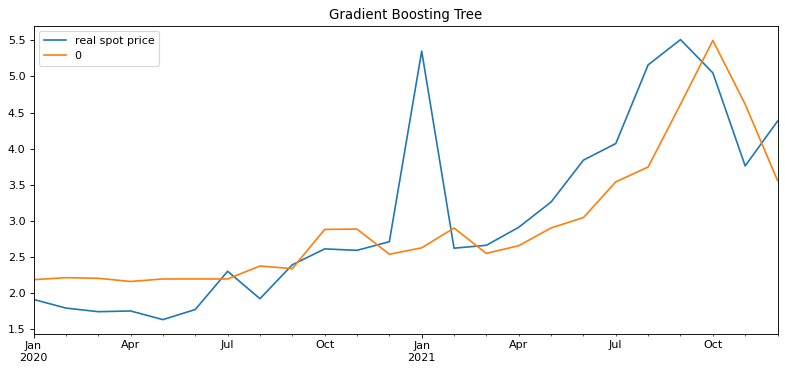

In [7]:
y_kxgb_pred = pd.DataFrame(reg.predict(X_test), index=y_test.index)
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_kxgb_pred)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_kxgb_pred.plot(ax=ax, label='forecasted spot price')
plt.title('Gradient Boosting Tree')
plt.legend()
plt.plot()

In [9]:
dict(zip(features, reg.feature_importances_))

{'US_gas_consumption': 0.022393866,
 'US_storage_volume': 0.014876691,
 'US_gas_exports': 0.023867615,
 'US_gas_imports': 0.020085301,
 'gas_rig_count': 0.040973086,
 'gas_marketed_production': 0.025079682,
 'WTI_spot_price': 0.016120242,
 'gas_futures_1': 0.76890844,
 'US_CPI': 0.012206258,
 'dow_jones': 0.015166275,
 '3m_treasury': 0.029003642,
 '5y_treasury': 0.011318867}